<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/Baryonator/blob/main/notebooks/Reweighting_demo_on_CAMELS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O snap_020.hdf5 https://users.flatironinstitute.org/~camels/Sims/IllustrisTNG/CV_0/snap_020.hdf5
!wget -O dm_snap_020.hdf5 https://users.flatironinstitute.org/~camels/Sims/IllustrisTNG_DM/CV_0/snap_020.hdf5

--2022-10-16 02:48:29--  https://users.flatironinstitute.org/~camels/Sims/IllustrisTNG/CV_0/snap_020.hdf5
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 104.18.28.64, 104.18.29.64, 2606:4700::6812:1d40, ...
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|104.18.28.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2524426594 (2.4G) [application/octet-stream]
Saving to: ‘snap_020.hdf5’

snap_020.hdf5       100%[===================>]   2.35G  37.1MB/s    in 75s     

2022-10-16 02:49:44 (32.1 MB/s) - ‘snap_020.hdf5’ saved [2524426594/2524426594]

--2022-10-16 02:49:44--  https://users.flatironinstitute.org/~camels/Sims/IllustrisTNG_DM/CV_0/snap_020.hdf5
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 104.18.28.64, 104.18.29.64, 2606:4700::6812:1c40, ...
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|104.18.28.64|:443... connected.
HTTP request sent, awaiting response.

In [ ]:
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!pip install --quiet optax tqdm

     |████████████████████████████████| 283 kB 8.4 MB/s 
     |████████████████████████████████| 145 kB 6.7 MB/s 
     |████████████████████████████████| 85 kB 4.5 MB/s 


In [ ]:
%pylab inline
import jax
import jax.numpy as jnp

import h5py

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.utils import power_spectrum
from jaxpm.utils import _initialize_pk
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, laplace_kernel, longrange_kernel

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#@title [Run Me]

import jax.lax as lax 

def cic_paint(mesh, positions, weights=None):
  """ Paints positions onto mesh
  mesh: [nx, ny, nz]
  positions: [npart, 3]
  weight: [npart]
  """
  positions = jnp.expand_dims(positions, 1)
  floor = jnp.floor(positions)
  connection = jnp.array([[[0, 0, 0], [1., 0, 0], [0., 1, 0], 
                           [0., 0, 1], [1., 1, 0], [1., 0, 1], 
                           [0., 1, 1], [1., 1, 1]]])

  neighboor_coords = floor + connection
  kernel = 1. - jnp.abs(positions - neighboor_coords)
  kernel = kernel[..., 0] * kernel[..., 1] * kernel[..., 2]  
  if weights is not None:
    kernel = kernel * weights[...,jnp.newaxis]

  neighboor_coords = jnp.mod(neighboor_coords.reshape([-1,8,3]).astype('int32'), jnp.array(mesh.shape))

  dnums = jax.lax.ScatterDimensionNumbers(
    update_window_dims=(),
    inserted_window_dims=(0, 1, 2),
    scatter_dims_to_operand_dims=(0, 1, 2))
  mesh = lax.scatter_add(mesh, 
                         neighboor_coords, 
                         kernel.reshape([-1,8]),
                         dnums)
  return mesh

def cross_correlation(field1, field2, kmin=5, dk=0.5, boxsize=False):
  shape = field1.shape
  nx, ny, nz = shape

  #initialze values related to powerspectra (mode bins and weights)
  dig, Nsum, xsum, W, k, kedges = _initialize_pk(shape, boxsize, kmin, dk)

  #fast fourier transform
  fft_image1 = jnp.fft.fftn(field1)
  fft_image2 = jnp.fft.fftn(field2)

  #absolute value of fast fourier transform
  pk = jnp.real(fft_image1 * jnp.conj(fft_image2))

  #calculating powerspectra
  real = jnp.real(pk).reshape([-1])
  imag = jnp.imag(pk).reshape([-1])

  Psum = jnp.bincount(dig, weights=(W.flatten() * imag), length=xsum.size) * 1j
  Psum += jnp.bincount(dig, weights=(W.flatten() * real), length=xsum.size)

  P = ((Psum / Nsum)[1:-1] * boxsize.prod()).astype('float32')

  #normalization for powerspectra
  norm = np.prod(np.array(shape[:])).astype('float32')**2

  #find central values of each bin
  kbins = kedges[:-1] + (kedges[1:] - kedges[:-1]) / 2

  return kbins, P / norm


def gaussian_kernel(kvec, k_smooth):
  """
  Computes a gaussian kernel
  """
  kk = sum(ki**2 for ki in kvec)
  return jnp.exp(-0.5 * kk / k_smooth**2)

In [ ]:
# This will define the mesh size we use to make 3d density maps 
# Note that the physical size of the volume is 25 Mpc/h on the side
# so one voxel is 25/128 Mpc/h on the side
mesh_shape = [128,128,128]

## Loading the snapshots

In [ ]:
# First, the full hydro run
data         = h5py.File('snap_020.hdf5', 'r')
BoxSize      = data['Header'].attrs[u'BoxSize']/1e3    #size of the snapshot in comoving Mpc/h
redshift     = data['Header'].attrs[u'Redshift']       #reshift of the snapshot
scale_factor = data['Header'].attrs[u'Time']           #scale factor
h            = data['Header'].attrs[u'HubbleParam']    #value of the hubble parameter in 100 km/s/(Mpc/h)
Masses       = data['Header'].attrs[u'MassTable']*1e10 #masses of the particles in Msun/h
Np           = data['Header'].attrs[u'NumPart_Total']  #total number of particles for specie
Omega_m      = data['Header'].attrs[u'Omega0']
Omega_L      = data['Header'].attrs[u'OmegaLambda']
Omega_b      = data['Header'].attrs[u'OmegaBaryon']

# Loading the DM particles
hydro_pos_dm  = data['PartType1/Coordinates'][:]/1e3  #Mpc/h
hydro_pos_dm = (hydro_pos_dm/BoxSize*mesh_shape[0])   #Rescaling positions to grid coordinates

# Loading the gas particles
hydro_pos_gas  = data['PartType0/Coordinates'][:]/1e3 #Mpc/h
hydro_pos_gas = (hydro_pos_gas/BoxSize*mesh_shape[0]) #Rescaling positions to grid coordinates
hydro_mass_gas = data['PartType0/Masses'][:]*1e10     #Msun/h 

In [ ]:
# Same thing for the DMO run
data         = h5py.File('dm_snap_020.hdf5', 'r')

# Loading the DM particles
dmo_pos_dm  = data['PartType1/Coordinates'][:]/1e3  #Mpc/h
dmo_pos_dm = (dmo_pos_dm/BoxSize*mesh_shape[0])   #Rescaling positions to grid coordinates

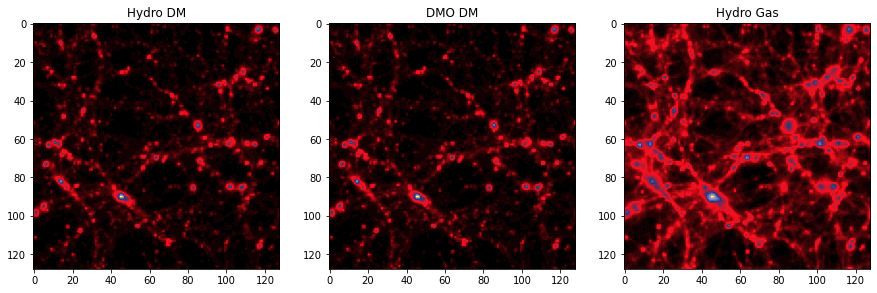

In [ ]:
figure(figsize=[15,5])
subplot(131)
title('Hydro DM')
imshow(cic_paint(jnp.zeros(mesh_shape), hydro_pos_dm).sum(axis=0), cmap='gist_stern');
subplot(132)
imshow(cic_paint(jnp.zeros(mesh_shape), dmo_pos_dm).sum(axis=0), cmap='gist_stern');
title('DMO DM')
subplot(133)
imshow(cic_paint(jnp.zeros(mesh_shape), hydro_pos_gas).sum(axis=0), cmap='gist_stern');
title('Hydro Gas');

## Comparing the two simulations

In [ ]:
# On the hydro side, let's add both DM and baryons
total_delta_hydro = cic_paint(jnp.zeros(mesh_shape), hydro_pos_dm)
total_delta_hydro = cic_paint(total_delta_hydro, hydro_pos_gas, 
                                weights=hydro_mass_gas/Masses[1])
total_delta_hydro = total_delta_hydro/total_delta_hydro.mean() - 1

gas_delta_hydro = cic_paint(jnp.zeros(mesh_shape), hydro_pos_gas, 
                                weights=hydro_mass_gas/Masses[1])
gas_delta_hydro = gas_delta_hydro/gas_delta_hydro.mean() - 1

In [ ]:
# On the DMO side, we only grab the dark matter
total_delta_dmo = cic_paint(jnp.zeros(mesh_shape), dmo_pos_dm)
total_delta_dmo = total_delta_dmo/total_delta_dmo.mean() - 1

In [ ]:
# Let's compute the power spectra
k, pk_hydro = power_spectrum(
      compensate_cic(total_delta_hydro),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

_, pk_dmo = power_spectrum(
      compensate_cic(total_delta_dmo),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

    
_,xpk=cross_correlation(compensate_cic(total_delta_hydro), compensate_cic(total_delta_dmo),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/usr/local/lib/python3.7/dist-packages/jax/_src/lax/lax.py:552: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

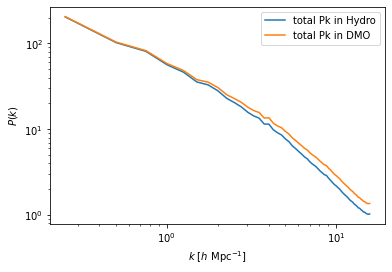

In [ ]:
loglog(k,pk_hydro, label='total Pk in Hydro')
loglog(k,pk_dmo, label='total Pk in DMO')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

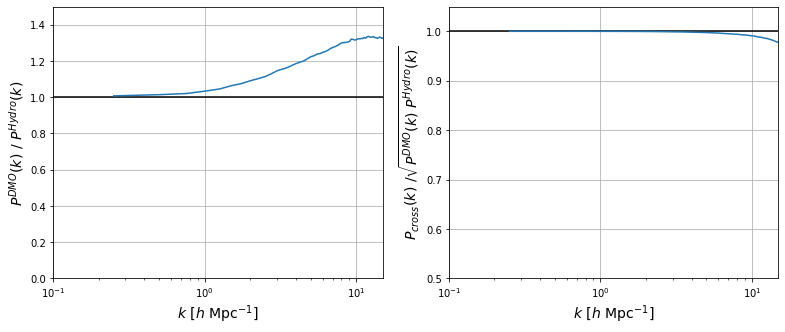

In [ ]:
figure(figsize=[13,5])
subplot(121)
axhline(1., color='black')
semilogx(k, (pk_dmo/pk_hydro))   
ylabel(r"$ P^{DMO}(k) \ / \ P^{Hydro}(k)$",fontsize=14)
xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]",fontsize=14)
ylim(0.,1.5)
xlim(0.1, 15)
plt.grid(True)

subplot(122)

axhline(1., color='black')
semilogx(k, xpk/(jnp.sqrt(pk_dmo)*jnp.sqrt(pk_hydro)))
grid()
xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]",fontsize=14)
ylabel(r"$ P_{cross}(k) \ / \sqrt{ P^{DMO}(k) \ P^{Hydro}(k)}$",fontsize=14);
ylim(0.5,1.05);
xlim(0.1, 15);

## Measuring the map rho, fscalar from simulations


So, the first thing we need to do is to measure the density contrast and this 
scalar quantity from the grid

In [ ]:
# Let's get delta for all the particles
rho_dm_dmo = cic_paint(jnp.zeros(mesh_shape), dmo_pos_dm)
rho_dm_dmo_part = cic_read(rho_dm_dmo, dmo_pos_dm)

In [ ]:
rho_dm_hydro = cic_paint(jnp.zeros(mesh_shape), hydro_pos_dm)
rho_dm_hydro = cic_paint(rho_dm_hydro, hydro_pos_gas, 
                                weights=hydro_mass_gas/Masses[1])
rho_dm_hydro_part = cic_read(rho_dm_hydro, dmo_pos_dm)

In [ ]:
# And compute this scalar force 
kvec = fftk(mesh_shape)
delta_k = jnp.fft.rfftn(rho_dm_dmo)
kk = sum(ki**2 for ki in kvec)
kk[kk == 0] = 1.
delta_k = delta_k / jnp.sqrt(kk)
fscalar = cic_read(jnp.fft.irfftn(delta_k), dmo_pos_dm)
# Maybe we clip fscalar
fscalar_dmo = jnp.clip(fscalar, 1e-1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  after removing the cwd from sys.path.


In [ ]:
delta_k = jnp.fft.rfftn(rho_dm_hydro)
kk = sum(ki**2 for ki in kvec)
kk[kk == 0] = 1.
delta_k = delta_k / jnp.sqrt(kk)
fscalar = cic_read(jnp.fft.irfftn(delta_k), hydro_pos_dm)
# Maybe we clip fscalar
fscalar_hydro = jnp.clip(fscalar, 1e-1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


In [ ]:
# Right, so now, we go to the hydro simulation, and we look at what the density looks 
# like as a function of these variables
# delta_hydro = cic_read(rho_dm_hydro, dmo_pos_dm)
# delta_hydro_g = cic_read(gas_delta_hydro + 1, dmo_pos_dm)

Text(0, 0.5, 'fscalar')

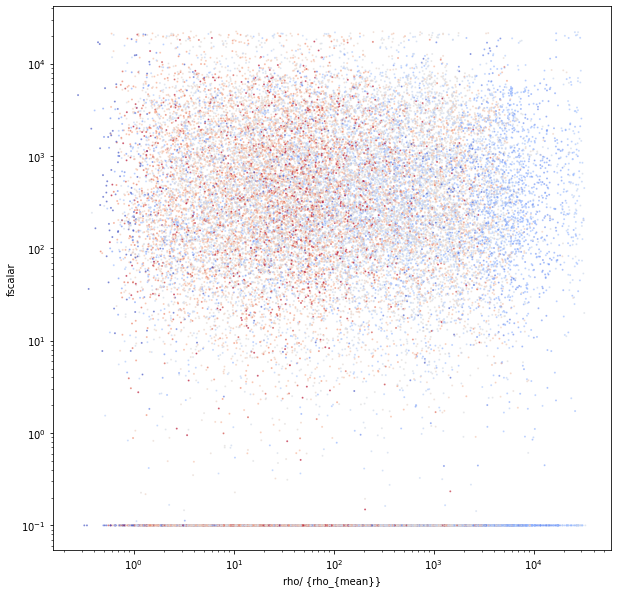

In [ ]:
figure(figsize=[10,10])
inds = np.random.permutation(arange(len(rho_dm_dmo_part)))[:30000]
scatter(rho_dm_hydro_part[inds], fscalar_hydro[inds], s=1.,
        c=rho_dm_hydro_part[inds]/rho_dm_dmo_part[inds],vmax=1.5,vmin=0.8,cmap='coolwarm',alpha=0.5);
xscale('log')
yscale('log')
xlabel('rho/ {rho_{mean}}')
ylabel('fscalar')

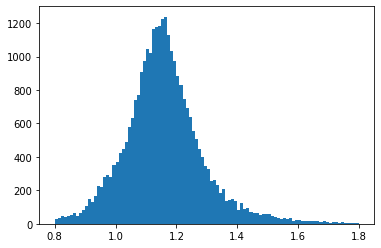

In [ ]:
hist(rho_dm_hydro_part[inds]/rho_dm_dmo_part[inds],100,range=[0.8,1.8]);

Text(0, 0.5, 'fscalar')

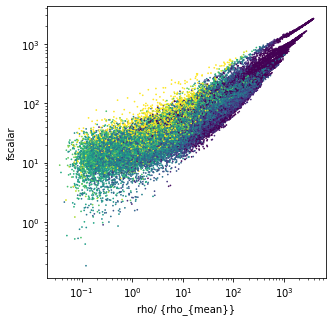

In [ ]:
figure(figsize=[5,5])
inds = np.random.permutation(arange(len(delta_dmo)))[:30000]
scatter(delta_dmo[inds], fscalar[inds]-fscalar.min(), s=0.5, c=delta_hydro_g[inds]/delta_dmo[inds],vmax=1.5,vmin=0.5);
xscale('log')
yscale('log')
xlabel('rho/ {rho_{mean}}')
ylabel('fscalar')

In [ ]:
figure(figsize=[5,5])
inds = np.random.permutation(arange(len(delta_dmo)))[:30000]
scatter(delta_dmo[inds], fscalar[inds]-fscalar.min(), s=0.5, c=delta_hydro[inds]/delta_dmo[inds],vmax=1.5,vmin=0.5);
xscale('log')
yscale('log')
xlabel('rho/ {rho_{mean}}')
ylabel('fscalar')

(-1.0, 1.0)

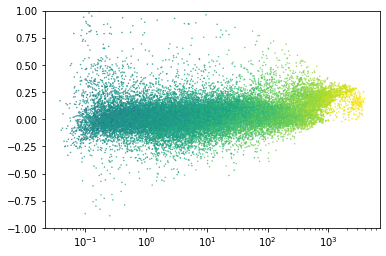

In [ ]:
scatter(delta_dmo[inds], (delta_dmo[inds] - delta_hydro[inds])/delta_hydro[inds],
        c=log10(fscalar[inds] - fscalar.min()), s=0.2);
xscale('log')
ylim(-1,1)

In [ ]:
c,x,y = histogram2d(jnp.log10(rho_dm_hydro_part), jnp.log10(fscalar_hydro), 100, range=[[-1,5],[-1,5]])
cw,x,y = histogram2d(jnp.log10(rho_dm_hydro_part), jnp.log10(fscalar_hydro), 100, 
                     weights=rho_dm_hydro_part/rho_dm_dmo_part,
                     range=[[-1,5],[-1,5]])
cw[c == 0] = 1.
c[c == 0] = 1.
x = 0.5*(x[:1] + x[1:])
y = 0.5*(y[:1] + y[1:])

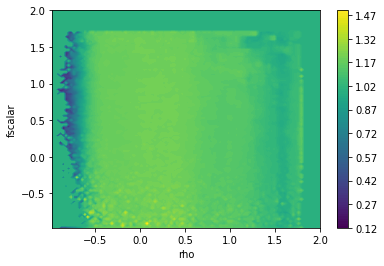

In [ ]:
contourf(x,y,cw.T/c.T,100)
xlabel('rho')
ylabel('fscalar');colorbar()

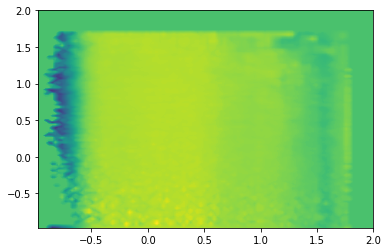

In [ ]:
from jax.scipy.ndimage import map_coordinates
xx, yy = np.meshgrid(x, y)

contourf(x,y, map_coordinates(cw/c, 
                                         jnp.stack([(xx - xx.min()) / (xx.max()-xx.min())*100 - 0.5, 
                                                    (yy - yy.min()) / (yy.max()-yy.min())*100 - 0.5], axis=0).reshape([2,-1]) , order=1, mode='nearest').reshape(100,100),
         256)

In [ ]:
def get_factor(delta_dmo, fs):
  xx = jnp.log10(delta_dmo)
  yy = jnp.log10(fs)
  return map_coordinates((cw/c).T, jnp.stack([(xx - xx.min()) / (xx.max()-xx.min())*100 - 0.5, 
                                          (yy - yy.min()) / (yy.max()-yy.min())*100 - 0.5], axis=0).reshape([2,-1]) , order=1, mode='nearest')

In [ ]:
part_weight = get_factor(rho_dm_dmo_part, fscalar_dmo)
part_weight = part_weight/part_weight.sum()*len(part_weight)

In [ ]:
part_weight

DeviceArray([1.0054837, 1.0068318, 1.007101 , ..., 0.9130313, 0.9130313,
             0.9130313], dtype=float32)

In [ ]:
weighted_density = cic_paint(jnp.zeros(mesh_shape), dmo_pos_dm, weights=part_weight)
                             #weights=delta_hydro/delta_dmo)
weighted_density = weighted_density/weighted_density.mean() - 1

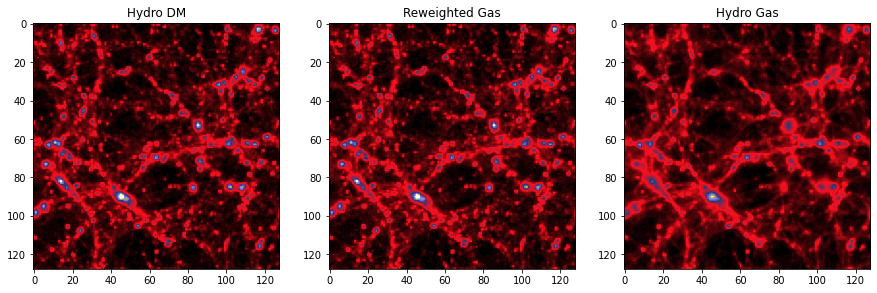

In [ ]:
figure(figsize=[15,5])
subplot(131)
title('Hydro DM');
d = cic_paint(jnp.zeros(mesh_shape), hydro_pos_dm)
d = d/d.mean() - 1 
imshow(d.sum(axis=0), cmap='gist_stern',vmax=3500);
subplot(132)
imshow(weighted_density.sum(axis=0), cmap='gist_stern',vmax=3500);
title('Reweighted Gas');
subplot(133)
d = cic_paint(jnp.zeros(mesh_shape), hydro_pos_gas)
d = d/d.mean() - 1 
imshow(d.sum(axis=0), cmap='gist_stern',vmax=3500);
title('Hydro Gas');

In [ ]:
_, pk_w = power_spectrum(
      compensate_cic(weighted_density),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

_,xpkw=cross_correlation(compensate_cic(total_delta_hydro), compensate_cic(weighted_density),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/usr/local/lib/python3.7/dist-packages/jax/_src/lax/lax.py:552: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


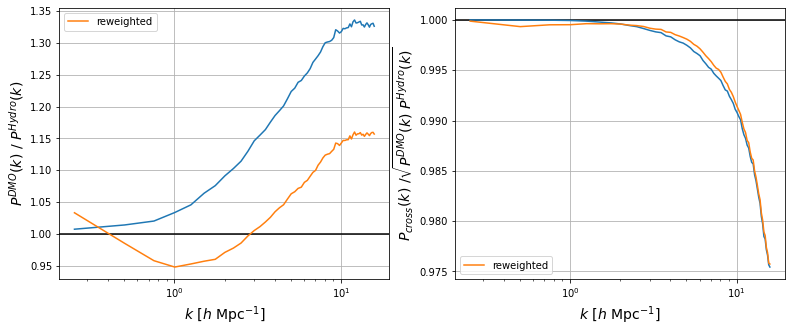

In [ ]:
figure(figsize=[13,5])
subplot(121)
axhline(1., color='black')
semilogx(k, (pk_dmo/pk_hydro))   
semilogx(k, (pk_w/pk_hydro), label='reweighted')   
ylabel(r"$ P^{DMO}(k) \ / \ P^{Hydro}(k)$",fontsize=14)
xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]",fontsize=14)

legend()
plt.grid(True)

subplot(122)

axhline(1., color='black')
semilogx(k, xpk/(jnp.sqrt(pk_dmo)*jnp.sqrt(pk_hydro)))
semilogx(k, xpkw/(jnp.sqrt(pk_w)*jnp.sqrt(pk_hydro)), label='reweighted')
grid()
xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]",fontsize=14)
ylabel(r"$ P_{cross}(k) \ / \sqrt{ P^{DMO}(k) \ P^{Hydro}(k)}$",fontsize=14);
legend()

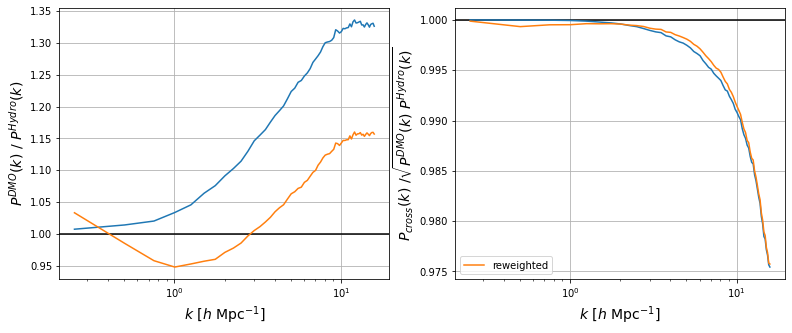

In [ ]:
# That's when we use the known density ratio at every particle
figure(figsize=[13,5])
subplot(121)
axhline(1., color='black')
semilogx(k, (pk_dmo/pk_hydro))   
semilogx(k, (pk_w/pk_hydro), label='reweighted')   
ylabel(r"$ P^{DMO}(k) \ / \ P^{Hydro}(k)$",fontsize=14)
xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]",fontsize=14)

plt.grid(True)

subplot(122)

axhline(1., color='black')
semilogx(k, xpk/(jnp.sqrt(pk_dmo)*jnp.sqrt(pk_hydro)))
semilogx(k, xpkw/(jnp.sqrt(pk_w)*jnp.sqrt(pk_hydro)), label='reweighted')
grid()
xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]",fontsize=14)
ylabel(r"$ P_{cross}(k) \ / \sqrt{ P^{DMO}(k) \ P^{Hydro}(k)}$",fontsize=14);
legend()

In [ ]:
# just for the gas
weighted_density = cic_paint(jnp.zeros(mesh_shape), dmo_pos_dm, weights=delta_hydro_g/delta_dmo)
weighted_density = weighted_density/weighted_density.mean() - 1

NameError: ignored

## Implementing vanilla Enthalpy Gradient Descent

Here we first attempt to reproduce the results of [Dai et al. 2018](https://arxiv.org/abs/1804.00671) which introduces a method coined EGD to displace DM particles in a DMO run into tracing the total matter distribution from a full hydro run.

In this work, the authors assume that a fraction $\Omega_b/\Omega_m$ of the particles will be displaced according to this EGD prescription. We are thus going to split our input DM particles into 2 populations, randomly.

In [ ]:
inds = jax.random.shuffle(jax.random.PRNGKey(42), jnp.arange(0,len(dmo_pos_dm)-1))
split = int(Omega_b/Omega_m*len(dmo_pos_dm))
egd_pos_gas = dmo_pos_dm[inds[:split]]
egd_pos_dm  = dmo_pos_dm[inds[split:]]

egd_rho_dm = cic_paint(jnp.zeros(mesh_shape), egd_pos_dm)

/usr/local/lib/python3.7/dist-packages/jax/_src/random.py:398: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


In [ ]:
def egd_correction(delta, pos, params):
    """
    Will compute the EGD displacement as a function of density traced by the 
    input particles.
    params contains [amplitude, scale, gamma]
    """
    kvec = fftk(mesh_shape)
    alpha, kl, gamma = params

    # Compute a temperature-like map from density contrast
    T = (delta+1)**gamma
    
    # Apply FFT to apply filtering
    T_k = jnp.fft.rfftn(T)
    filtered_T_k = gaussian_kernel(kvec, kl) * T_k # This applies a Gaussian smoothing

    # Compute derivatives of this filtered T-like field at the position of particles
    dpos_egd = jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*filtered_T_k), pos) 
                      for i in range(3)],axis=-1)
    
    # Apply overal scaling of these displacements
    dpos_egd = - alpha * dpos_egd
   
    return dpos_egd

Now let's try to optimize parameters of this model

In [ ]:
import optax # This is a JAX optimizer package
from tqdm import tqdm
learning_rate = 0.1
optimizer = optax.adam(learning_rate)

In [ ]:
# I define my loss function
@jax.jit
def loss_fn(params):
  egdized_pos_gas = egd_pos_gas + egd_correction(total_delta_dmo, egd_pos_gas, params)

  # Add the gas that we have moved to the dm that stayed where it was
  delta = cic_paint(egd_rho_dm, egdized_pos_gas)
  delta = delta/delta.mean() - 1.

  # Compute the PS of everybody
  k,pk=power_spectrum(compensate_cic(delta),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)
  
  # Some weighting function of the pk, following Biwei's strategy
  inds = k < 10.
  return jnp.sum(((pk/pk_hydro -1))[inds]**2,axis=-1)
  # return jnp.sum( (delta-total_delta_hydro)**2)

# And the optimizer update function (this is common optax boiler plate)
@jax.jit
def update(params, opt_state):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

In [ ]:
# Let's initialize parameters and optimizer
params = [0.5, 1.4, 0.4] # amplitude, scale, gamma
opt_state = optimizer.init(params)
losses = []

In [ ]:
for step in tqdm(range(1000)):
  l, params, opt_state = update(params, opt_state)
  losses.append(l)

[DeviceArray(0.93629056, dtype=float32),
 DeviceArray(2.0582693, dtype=float32),
 DeviceArray(0.46008348, dtype=float32)]

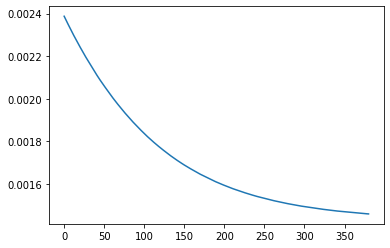

In [ ]:
plot(losses[200:]);
params

In [ ]:
# Let's look at the result
# On the DMO side, we only grab the dark matter
total_delta_egd = cic_paint(egd_rho_dm, 
                            egd_pos_gas + egd_correction(total_delta_dmo, egd_pos_gas, params))
total_delta_egd = total_delta_egd/total_delta_egd.mean() - 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


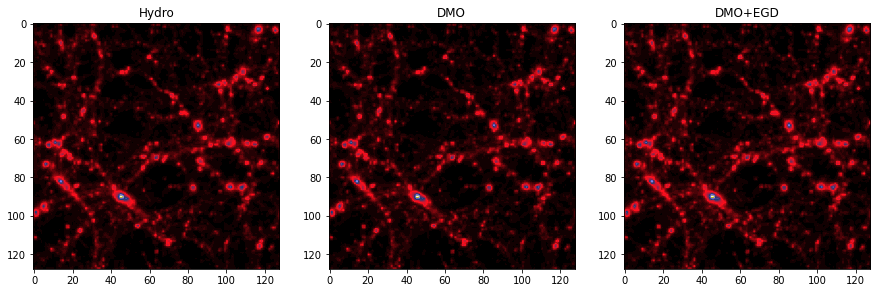

In [ ]:
# First lets make a plot
figure(figsize=[15,5])
subplot(131)
title('Hydro')
imshow(total_delta_hydro.sum(axis=0), cmap='gist_stern');
subplot(132)
imshow(total_delta_dmo.sum(axis=0), cmap='gist_stern');
title('DMO')
subplot(133)
imshow(total_delta_egd.sum(axis=0), cmap='gist_stern');
title('DMO+EGD');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


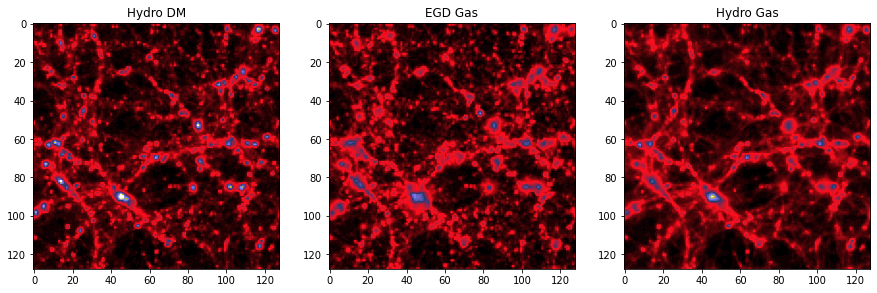

In [ ]:
figure(figsize=[15,5])
subplot(131)
title('Hydro DM');
d = cic_paint(jnp.zeros(mesh_shape), hydro_pos_dm)
d = d/d.mean() - 1 
imshow(d.sum(axis=0), cmap='gist_stern',vmax=3500);
subplot(132)
d = cic_paint(jnp.zeros(mesh_shape), egd_pos_gas + egd_correction(total_delta_dmo, egd_pos_gas, params))
d = d/d.mean() - 1 
imshow(d.sum(axis=0), cmap='gist_stern',vmax=3500);
title('EGD Gas');
subplot(133)
d = cic_paint(jnp.zeros(mesh_shape), hydro_pos_gas)
d = d/d.mean() - 1 
imshow(d.sum(axis=0), cmap='gist_stern',vmax=3500);
title('Hydro Gas');

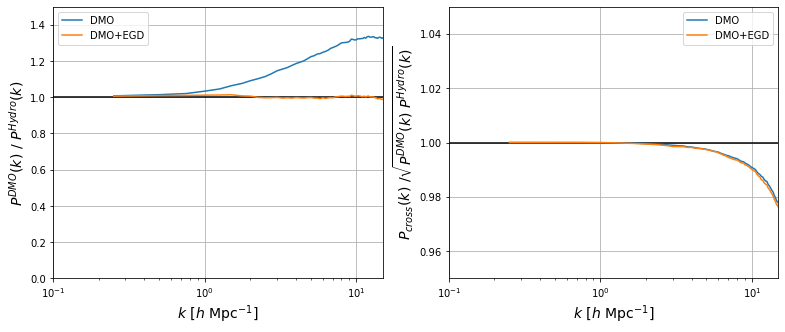

In [ ]:
# Now let's compute 2pt stats
_, pk_egd = power_spectrum(
      compensate_cic(total_delta_egd),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

_,xpk_egd=cross_correlation(compensate_cic(total_delta_hydro), compensate_cic(total_delta_egd),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

figure(figsize=[13,5])
subplot(121)
axhline(1., color='black')
semilogx(k, (pk_dmo/pk_hydro), label='DMO')   
semilogx(k, (pk_egd/pk_hydro), label='DMO+EGD')   
ylabel(r"$ P^{DMO}(k) \ / \ P^{Hydro}(k)$",fontsize=14)
xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]",fontsize=14)
ylim(0.,1.5)
xlim(0.1, 15)
legend()
plt.grid(True)

subplot(122)

axhline(1., color='black')
semilogx(k, xpk/(jnp.sqrt(pk_dmo)*jnp.sqrt(pk_hydro)), label='DMO')
semilogx(k, xpk_egd/(jnp.sqrt(pk_egd)*jnp.sqrt(pk_hydro)), label='DMO+EGD')
grid()
xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]",fontsize=14)
ylabel(r"$ P_{cross}(k) \ / \sqrt{ P^{DMO}(k) \ P^{Hydro}(k)}$",fontsize=14);
ylim(0.95,1.05);
xlim(0.1, 15);
legend()